In [70]:
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
from math import sqrt
import scipy.stats as stats
from scipy import optimize
import matplotlib.colors as colors
from numpy.random import Generator, PCG64
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy import Point
from geopy.distance import distance
from geopy import units
from IPython.display import clear_output, display
import random
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'
rng = Generator(PCG64(seed=0))
ds = xr.open_dataset("ERA5_CF_202007.nc") #july 2020
print(ds)


<xarray.Dataset>
Dimensions:     (latitude: 201, longitude: 445, time: 744)
Coordinates:
  * longitude   (longitude) float32 -31.0 -30.75 -30.5 ... 79.5 79.75 80.0
  * latitude    (latitude) float32 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * time        (time) datetime64[ns] 2020-07-01 ... 2020-07-31T23:00:00
Data variables:
    solarCF     (time, latitude, longitude) float32 ...
    windCF_off  (time, latitude, longitude) float32 ...
    windCF_on   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-24 20:57:21 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...
    author:       Laurens Stoop UU/KNMI/TenneT
    created:      27-01-2022
    map_area:     Europe
    data_source:  ERA5 reanalysis data, contains modified Copernicus Climate ...


<h2>Handy Functions</h2>

In [14]:
#Find the (lat,lon) pair that actually exists in the dataset ds
def getActualCoords(lat, lon):
    lat_var = ds['latitude']
    lon_var = ds['longitude']

    #Get the lat,lon pair from the dataset
    actualpair = ds.sel(latitude=lat, longitude=lon,method='nearest')
    return (actualpair.latitude.values.item(), actualpair.longitude.values.item())

In [15]:
#Display the time series plot for a given location present in the ds
def plotSolarCF(lat,lon):
    solar_cf = ds['solarCF'].sel(latitude=lat, longitude=lon)

    fig, ax = plt.subplots(figsize=(10, 6))
    solar_cf.plot(ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.xticks(pd.date_range(start=solar_cf.time.values[0], end=solar_cf.time.values[-1], freq='48H'))
    fig.patch.set_facecolor('white')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %Hh'))


    ax.set_title(f'SolarCF for (lat={lat}, lon={lon})')
    ax.set_xlabel('Time')
    ax.set_ylabel('SolarCF')
    display(fig)
    plt.close(fig)

In [67]:
#Get the correlation between two time series at two locations (the same location for both inputs should give correlation 1).

def pairCorrelation(loc1, loc2):
    #Extract solarCF data for loc1 and loc2
    solarCF1 = ds.solarCF.sel(latitude=loc1[0], longitude=loc1[1])
    solarCF2 = ds.solarCF.sel(latitude=loc2[0], longitude=loc2[1])

    #Calculate the correlation coefficient between the two time series, and return the relevant value from the resulting matrix
    corr_coef = np.corrcoef(solarCF1, solarCF2)[0, 1]

    return corr_coef

loc1 = (30,80)
loc2 = (80,-31)
print(pairCorrelation(loc1,loc2))


-0.22865424690144082


In [176]:
#Get location at a given distance from a lat,lon coordinate.

def getLoc(lat, lon, d, angle):
    # Convert input latitude and longitude to a geopy Point object
    input_loc = Point(lat, lon)
    
    # Generate a random bearing in degrees between 0 and 360 using numpy

    
    # Calculate the destination location using geopy distance and bearing
    destination = distance(kilometers=d).destination((lat,lon), bearing=angle)
    
    # Return the latitude and longitude of the destination location
    return getActualCoords(destination.latitude, destination.longitude)



In [69]:
#function shape for fitting model.
def cordist(d,D): 
    rho = 2**(-d/D)
    return(rho)

In [59]:
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values
print("Possible (lat, lon) combinations:")
lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()

print(f"Minimum latitude: {lat_min}")
print(f"Maximum latitude: {lat_max}")
print(f"Minimum longitude: {lon_min}")
print(f"Maximum longitude: {lon_max}")

print(len(latitudes) * len(longitudes))

Possible (lat, lon) combinations:
Minimum latitude: 30.0
Maximum latitude: 80.0
Minimum longitude: -31.0
Maximum longitude: 80.0
89445


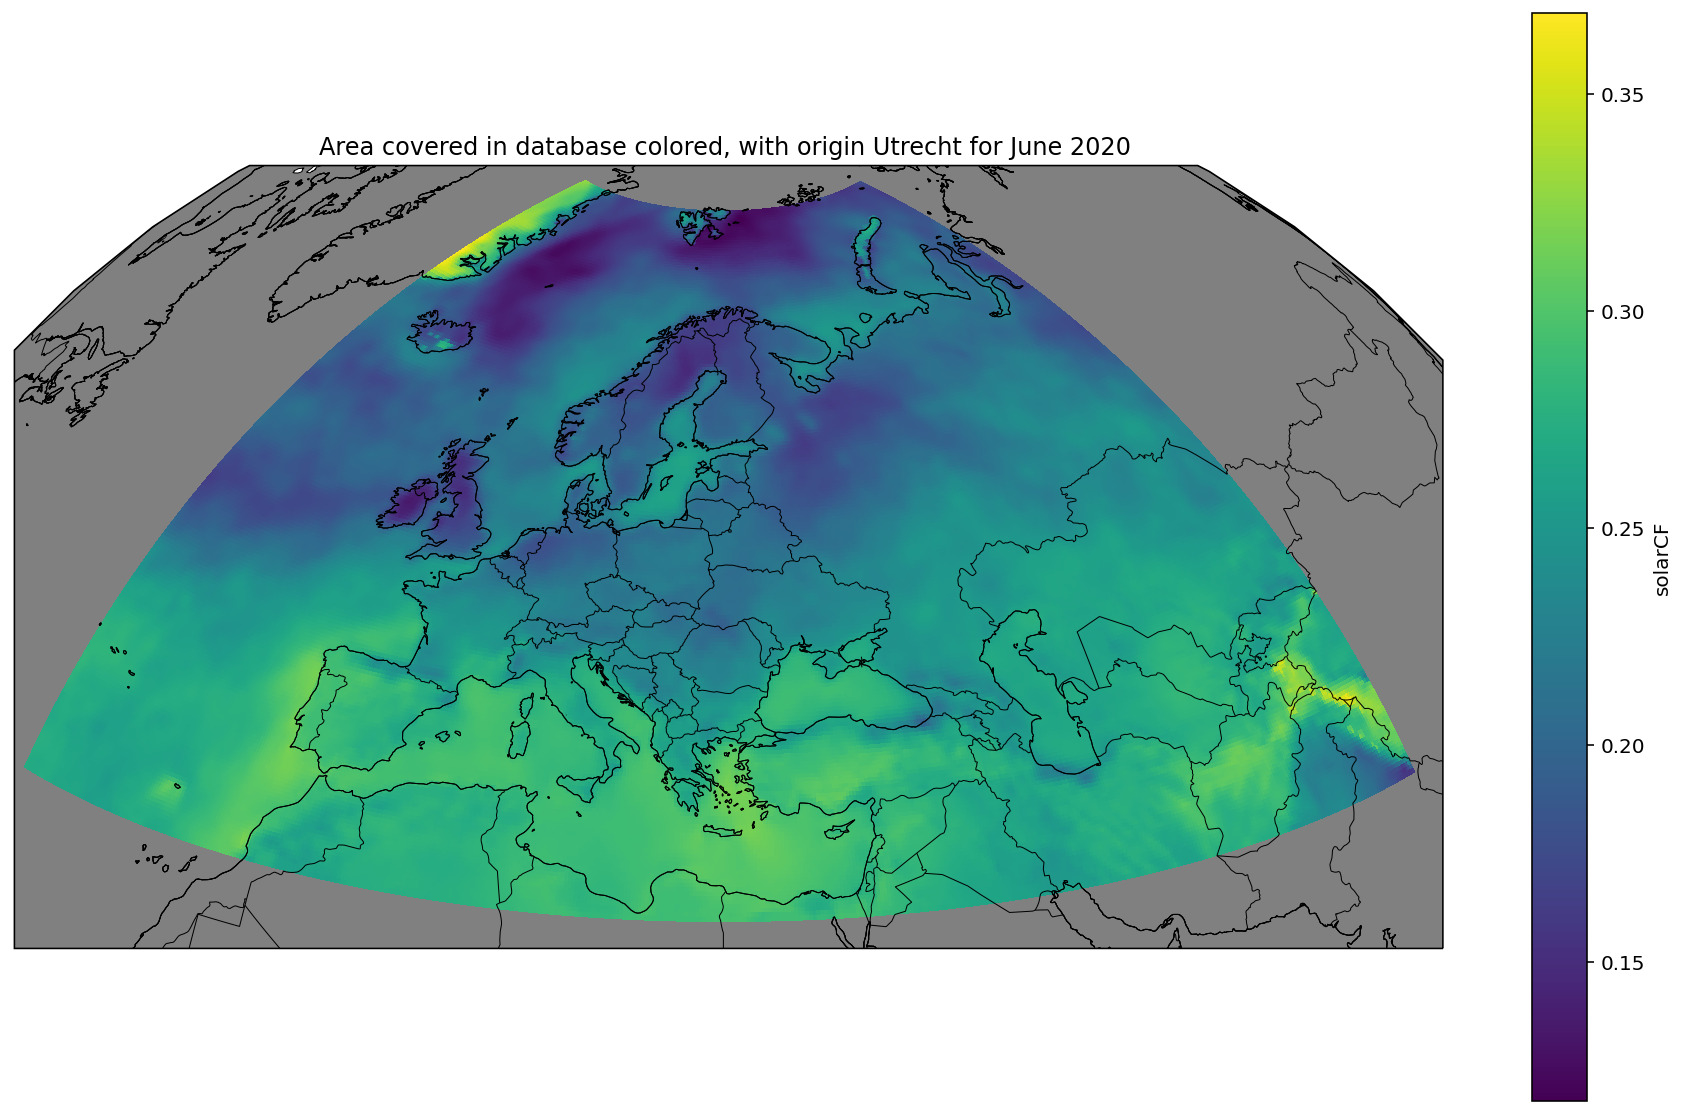

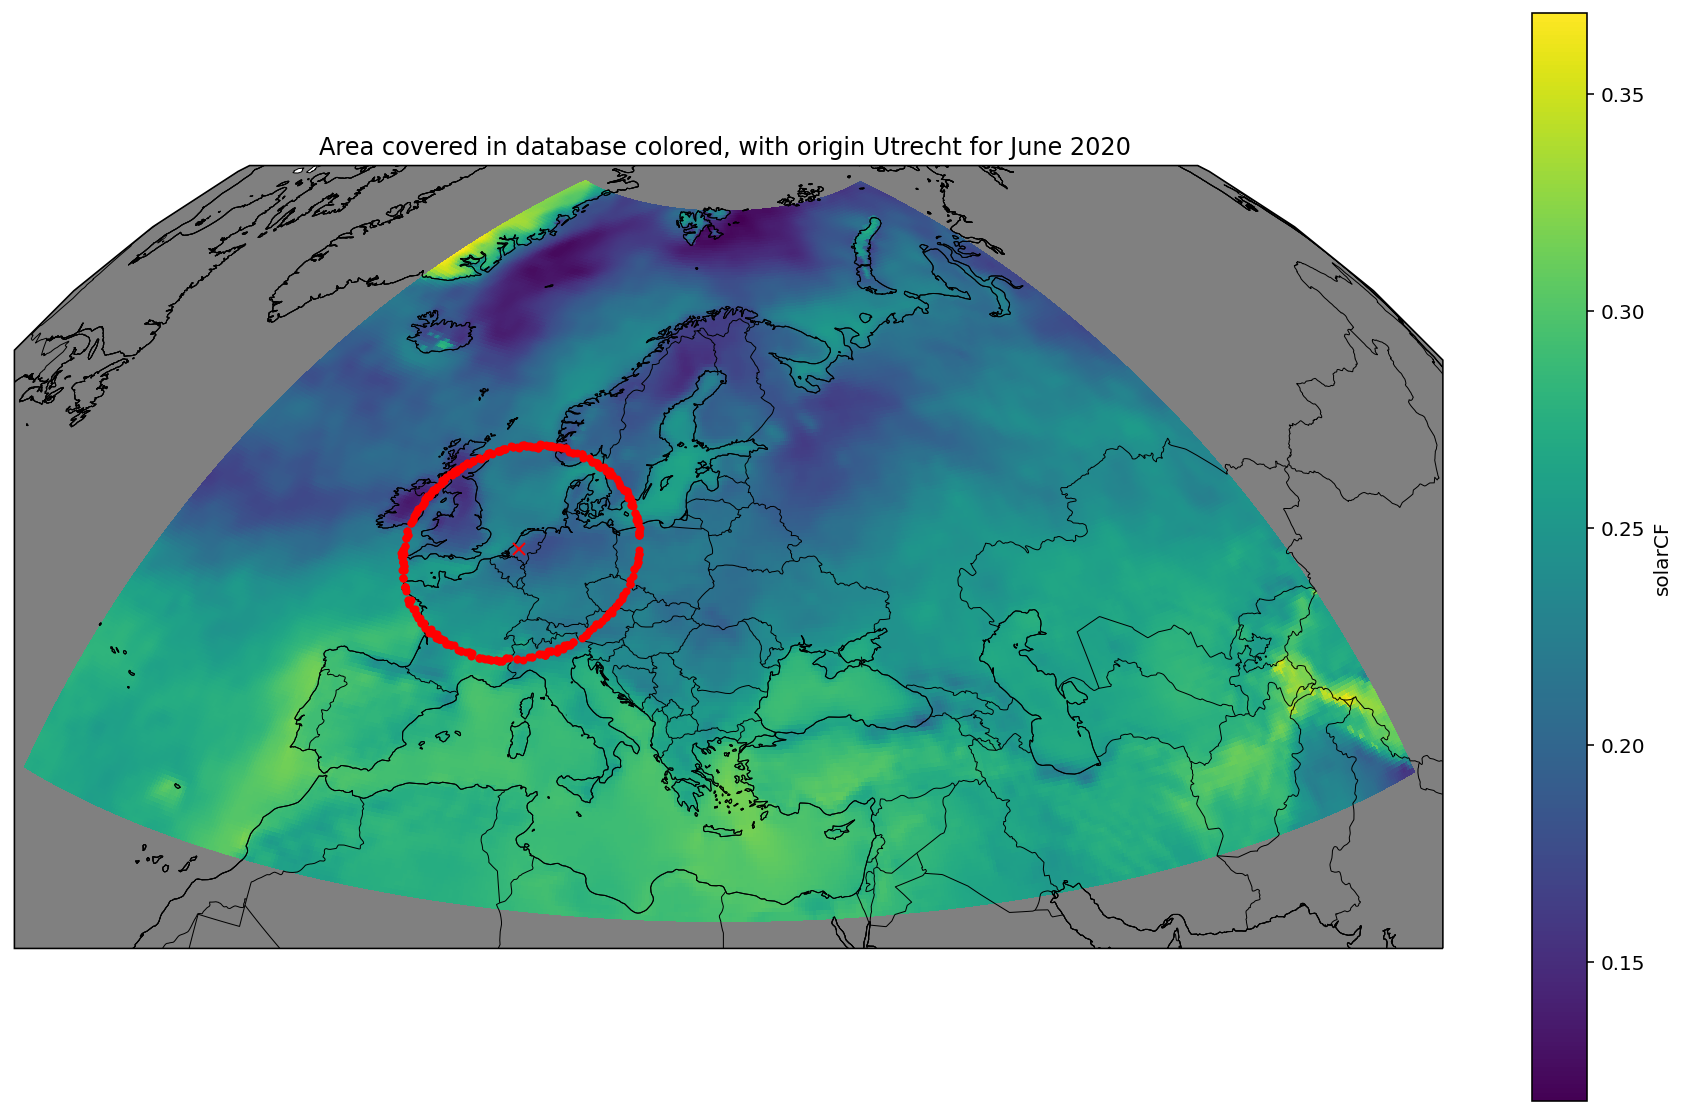

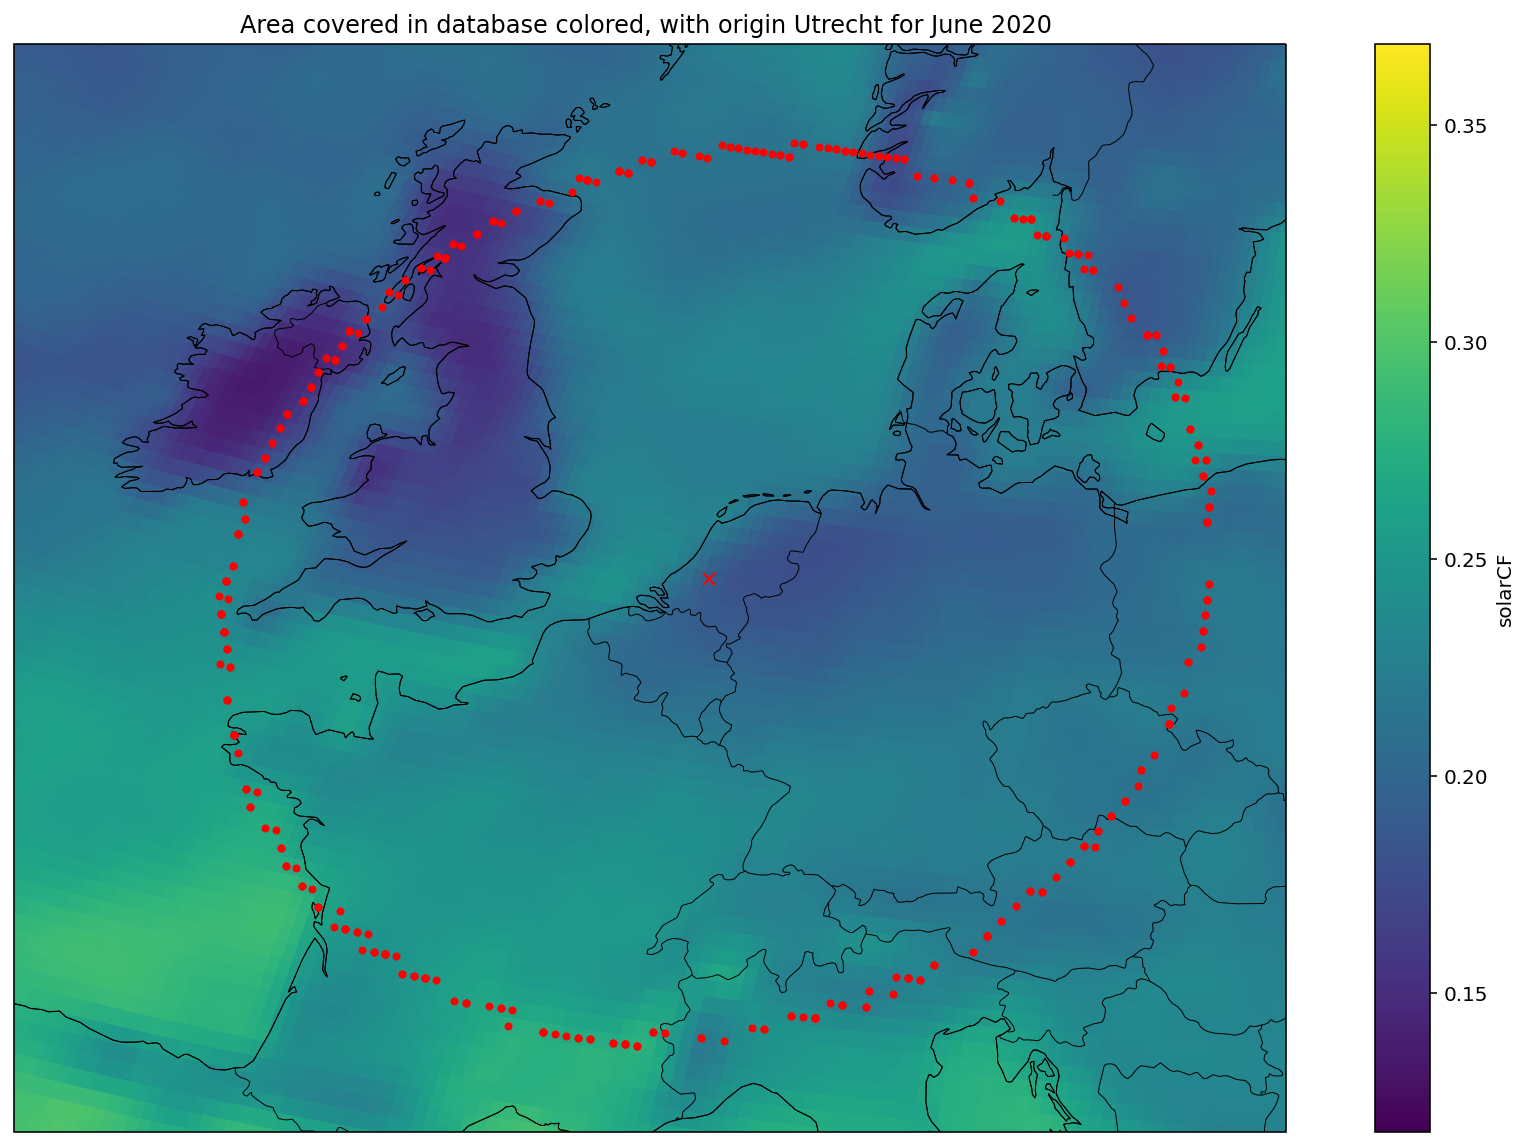

In [177]:
%matplotlib inline

#utrecht= (52.0907, 5.1214)
utrecht = (52.0,5.0)

amsterdam = (52.3676, 4.9041)
berlin = (52.5200, 13.4050)
florence = (43.7696,11.2558)
madrid = (40.4168, -3.7038)
zurich = (47.3769, 8.5417)


def rnd_dark():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    # Return the color as an RGB tuple
    return (r/255, g/255, b/255)

#lat_min +=5
#lat_max -= 5
#lon_min += 5
#lon_max -=5

edges = [(lat_min+5, lon_min+5), (lat_max-5, lon_min+5), (lat_max-5, lon_max-5), (lat_min+5, lon_max-5)]
def gridPlot(origincell,samplelist):
    centerlat = (lat_min + lat_max) / 2
    centerlon = (lon_min + lon_max) / 2

    # the coordinates of utrecht
    #lat_utrecht, lon_utrecht = 52.0907, 5.1214

    #Plot the data map
    solarCF = ds.solarCF
    time_idx = 12

    #this is for one single timestep
    #p1 = solarCF.isel(time=time_idx).plot(
    #    transform=ccrs.PlateCarree(),
    #    subplot_kws={"projection": ccrs.Orthographic(centerlat-30, centerlon), "extent": (lon_min+5, lon_max-3, lat_min-10, lat_max+3)},
        #cmap=colors.ListedColormap(['white']),
        #add_colorbar=False,
    #)

    # Calculate the mean CF over time
    mean_solarCF = ds.solarCF.mean(dim='time')

    #Plot the mean CF using the calculated mean data
    p = mean_solarCF.plot(
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.Orthographic(centerlat-30, centerlon), "extent": (lon_min+5, lon_max-3, lat_min-10, lat_max+3)},
    #cmap=colors.ListedColormap(['white']),
    #add_colorbar=False,
    )

    ax = plt.gca()
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black', linewidth=0.5)

    ax.add_feature(cfeature.LAND.with_scale('50m'), linewidth=0.5, facecolor='gray', edgecolor='black', zorder=0)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), linewidth=0.5, facecolor='gray', edgecolor='black', zorder=0)


    #ax.plot(lon_utrecht, lat_utrecht, marker='x', color='red', markersize=7.5, alpha=1, transform=ccrs.PlateCarree())

    time_string = pd.Timestamp(solarCF.time.values[time_idx]).strftime("%Y-%m-%d %H:%M:%S")
    p.axes.set_title("Area covered in database colored, with origin Utrecht for June 2020 ")

    fig = plt.gcf()
    fig.set_size_inches(16, 10)
    fig.set_facecolor('white')

    return ax,fig,plt #return figure to be used in other functions

ax,fig,plt = gridPlot(utrecht,edges)
display(fig)

#Function to add markers to existing map
def addMarkers(ax,origin,lst):
    lst.append(origin)

    for i,pnt in enumerate(lst):
        if i == len(lst) - 1:
            dist_text = "origin"
            ax.plot(pnt[1], pnt[0], marker='x', color='red', markersize=6, transform=ccrs.PlateCarree())
        else:    
            dist_text = str(round(distance(utrecht,pnt).km)) + "km"
            ax.plot(pnt[1], pnt[0], marker='o', color='red', markersize=3, transform=ccrs.PlateCarree())
        #ax.annotate(dist_text, xy=(pnt[1], pnt[0]), xytext=(4, 4), textcoords='offset points',transform=ccrs.PlateCarree(),bbox=dict(facecolor='white', edgecolor='black', pad=len(dist_text)*0.01, boxstyle='round'))
    lst.pop()
        #set the extent of the axis object
        #ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

def zoom(ax, origin, lst):
    lon_pad = 0.5
    lat_pad = 0.5
    lst.append(origin)  #add it to list of markers temporarily 

    min_lon = min(lon for lat, lon in lst ) - lon_pad
    max_lon = max(lon for lat, lon in lst ) + lon_pad
    min_lat = min(lat for lat, lon in lst) - lat_pad
    max_lat = max(lat for lat, lon in lst) + lat_pad
    lst.pop() #remove origin from marker list

    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())



#Get all points around a given center
def getCirclePoints(center, distance_km):


    pointlst = []

    # Loop over bearings from 1 to 359 degrees
    for bearing in range(0, 360):
        #Calculate destination point using geopy.distance.distance() function
        destination = distance(kilometers=distance_km).destination(center, bearing)
        #Obtain actual existing coordinates in the database
        actualpoint = getActualCoords(destination.latitude,destination.longitude)
        pointlst.append((actualpoint[0], actualpoint[1]))

    # Return list of destination points
    return pointlst


#lst = getCirclePoints(utrecht,2000)

lst = []
rng = Generator(PCG64(seed=0))
for i in range(0,360):
    angle = rng.uniform(0, 360)
    lst.append(getLoc(utrecht[0],utrecht[1],800,angle))


addMarkers(ax,utrecht,lst)
display(fig)
zoom(ax,utrecht,lst)






<h2>Uncertainty Sampling for Utrecht (52,5)</h2>

In [200]:
#np.#random.seed(8)
#Holds list of values for each repetition
iterations = 1000
ValueTRUE = 400
rng = Generator(PCG64(seed=1)) #seed generator for random values

#stopping criteria
stdSC = 17 
scdiff = 3
startcount = 1
maxcount = 3

origin = (52.0,5.0) #Utrecht province
og0 = origin[0]
og1 = origin[1]


LowerBound = 100
UpperBound = 1000
locLB = getLoc(og0,og1, LowerBound,rng.uniform(0, 360))
locUB = getLoc(og0,og1,UpperBound,rng.uniform(0, 360))


rp0 = rng.uniform(100, 1000) #sample initial random guess of D-hat for curve fitting

Dhat_arr = []
cov_arr = []

rhoLB = pairCorrelation(origin,locLB) #get corr.
rhoUB = pairCorrelation(origin,locUB)

x = [LowerBound,UpperBound] #add distances from origin point to this list
y = [rhoLB,rhoUB] #store corresponding rho values in y list
locs = [locLB,locUB]

q2 = 0.5* (LowerBound+UpperBound)
locq2 = getLoc(og0,og1, 0.5* (LowerBound+UpperBound) ,rng.uniform(0, 360))
rhoq2 = pairCorrelation(origin,locq2)

x.append(q2)
y.append(rhoq2)
locs.append(locq2)

params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
cov_arr.append(sqrt(covs[0][0]))

i_arr = [0]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.


for i in range(0,iterations):
        i_arr.append(i+1) #update every iteration

        sf = (1.5)
        for j in range(0,4): #take 4 points per iteration
            
            #print("scalefactor",sf)
            b =  Dhat_arr[i-1] + sf * cov_arr[i-1] #the two interval bounds
            a =  Dhat_arr[i-1] - sf * cov_arr[i-1]

            #if a is negative, take 4 random points and move to next iteration of loop to prevent NaN error
            if a < 0: 
                #print("negative a on j ->",j,"count:",negcount)
                for k in range(0,4-j): #only take as many random points as needed
                    d = rng.uniform(LowerBound,UpperBound)
                    loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))
                    rhod = pairCorrelation(origin,loc_d)
                    x.append(d)
                    y.append(rhod)
                    locs.append(loc_d)
                break
                
            d = - (a*b*np.log(a/b)) / (np.log(2)*(b-a)) #get the max. distance between the curves; natural log by default for numpy
            loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))
            rhod = pairCorrelation(origin,loc_d)
            x.append(d)
            y.append(rhod)
            locs.append(loc_d)
            sf+= 0.5 

        
        params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
        Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
        cov_arr.append(sqrt(covs[0][0]))

         #triple s.c. -> past 10 iterations, if |Dhat - prev Dhat| < 3km for at least 3 iters, and s.d. < 17km, then stop
        if(i > 10 ):
            absdiff = abs(params[0] - Dhat_arr[-2]) #estimate difference between current and previous iteration
            if (absdiff < scdiff):
                startcount+=1
            else:
                startcount = 0

            if (startcount >= maxcount and cov_arr[-1]<stdSC): 
                "stopping criteria reached"
                break #end the algorithm in this case


In [204]:
print(x)
print("total no. of samples for Uncertainty",len(x))
print(cov_arr)
print(Dhat_arr)

[100, 1000, 550.0, 3571.012227957118, 3571.0117998333826, 3571.0112493887955, 3571.010576623007, 3571.012227957118, 3571.0117998333826, 3571.0112493887955, 3571.010576623007, 9790.152572397415, 9790.151983538937, 9790.151226434271, 9790.150301084828, 10250.964431196198, 10250.964029613795, 10250.963513295199, 10250.962882237243, 11368.934211844797, 11368.933729579287, 11368.933109522462, 11368.932351676181, 9756.833396788032, 9756.833127500102, 9756.832781274461, 9756.832358107622, 11884.24376321844, 11884.24338623335, 11884.24290153884, 11884.242309135372, 12861.003358997667, 12861.002999582977, 12861.002537479342, 12861.00197268791, 13234.627589787558, 13234.627250675501, 13234.62681467531, 13234.626281784682, 15156.261909932346, 15156.26155033409, 15156.261087991803, 15156.260522908511, 15226.076305531027, 15226.07598548397, 15226.075573995582, 15226.075071064904, 16220.715560067325, 16220.715246020643, 16220.714842247327, 16220.714348742435, 18065.901492518304, 18065.901153325052, 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


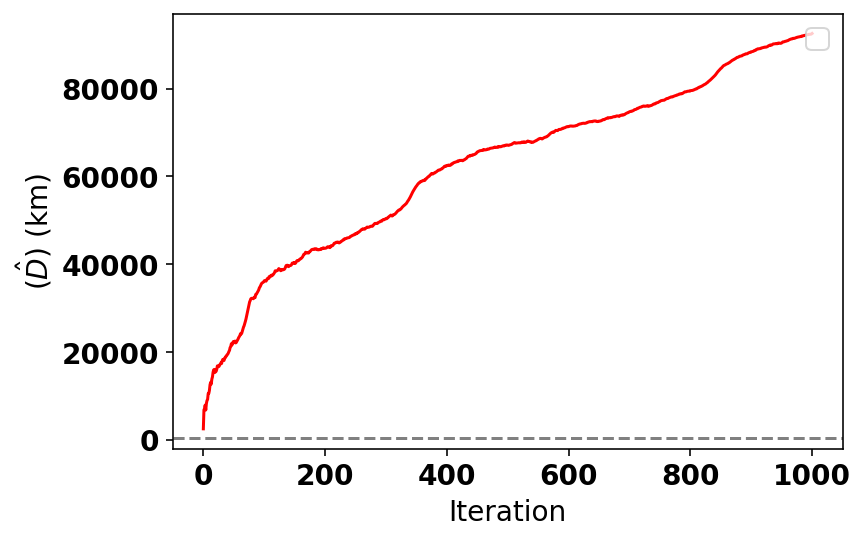

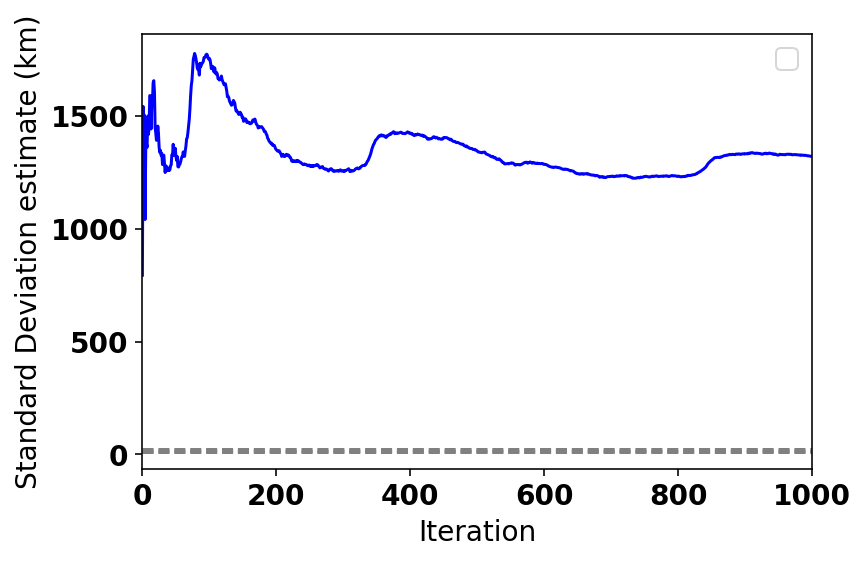

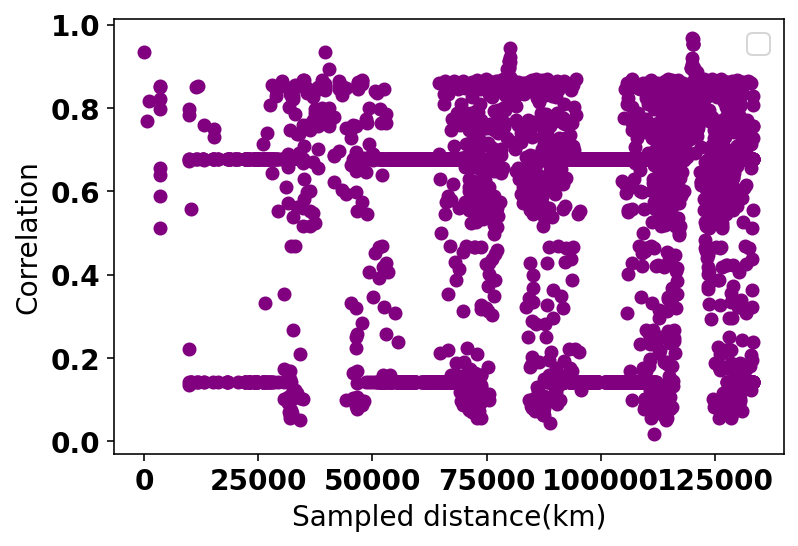

In [206]:
font = {
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

def absdiff(i):
    return (i-ValueTRUE)
#Dhat_arr_u_diff = [absdiff(i) for i in Dhat_arr] 
plt.figure(8)
plt.plot(i_arr,Dhat_arr, c='red')#,label='Uncertainty sampling' ) #systematic random
plt.axhline(y=400, color='gray', linestyle='--')
plt.ylabel('($\hat{D}$) (km)')
plt.xlabel('Iteration')  
plt.legend(loc="upper right")
plt.figure(9)
plt.plot(i_arr,cov_arr, c='blue')#,label='Un' ) #systematic random
plt.axhline(y=25, color='gray', linestyle='--')
plt.axhline(y=17, color='gray', linestyle='--')
plt.axhline(y=10, color='gray', linestyle='--')
plt.ylabel('Standard Deviation estimate (km)') # LPS: As there is only one variable, this is the variance of this variable. 
plt.xlabel('Iteration')  
plt.xlim(0,1000)
plt.legend(loc="upper right")

plt.figure(11)
plt.scatter(x,y,color='purple')#,label='U\'s Sampled Distances'
plt.ylabel('Correlation')
plt.xlabel('Sampled distance(km)')  
plt.legend(loc="upper right")

one point per distance in a random direction.

to evaluate -> check correlation at CD given by model. take lat,lon by taking every  degree in a "circle", making sure each coord is taken only once.

for map, plot avg (mean) values of solar (or wind) cf.

for solar mean, do groupby of the hour of the day (eg only take timestamps that are 12pm)

always take 4 sample grid cells. if you have a given sample distance, 